In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mlflow
from hydra import initialize, compose
from hydra.utils import instantiate
from chemprop import data, featurizers, models
from chemprop.nn.message_passing import BondMessagePassing
import torch
from torch.utils.data import DataLoader
import lightning as L
from ergochemics.mapping import rc_to_nest
from rdkit import Chem
from cgr.ml import collate_batch, sep_aidx_to_bin_label, GNN, LinearPredictor
from sklearn.model_selection import train_test_split, GroupKFold

from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    precision_score,
    recall_score,
    accuracy_score,
    f1_score
)

with initialize(version_base=None, config_path="../artifacts/train_conf/2025-05-06/12-28-04/1/.hydra/"):
    cfg = compose(config_name="config")

In [4]:
mlflow.set_tracking_uri(f"file://{cfg.filepaths.mlruns}")

In [5]:
experiment_name = "outer_splits"
experiment = mlflow.get_experiment_by_name(experiment_name)

if experiment:
    df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
else:
    print(f"Experiment '{experiment_name}' not found.")

In [6]:
df.head()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.test_recall,metrics.test_acc,metrics.test_precision,metrics.test_auroc,...,params.data/outer_splitter/_target_,params.training/init_lr,params.data/inner_splitter/shuffle,params.training/max_epochs,tags.source,tags.mlflow.runName,tags.mlflow.source.name,tags.mlflow.source.type,tags.mlflow.user,tags.mlflow.source.git.commit
0,d93073d08d604a4cb196d812ef47a36a,440769810419849909,FINISHED,file:///home/stef/cgr/artifacts/mlruns/4407698...,2025-05-09 15:22:12.903000+00:00,2025-05-09 15:27:13.815000+00:00,0.738250,0.938211,0.880714,0.963479,...,sklearn.model_selection.GroupKFold,0.0009067815616740716,True,16,train.py,bemused-goat-855,train.py,LOCAL,stef,None
1,41f2915bf29a4528ab12740528259c1d,440769810419849909,FINISHED,file:///home/stef/cgr/artifacts/mlruns/4407698...,2025-05-07 16:54:51.700000+00:00,2025-05-07 16:54:53.387000+00:00,0.151899,0.738406,0.095618,0.462030,...,sklearn.model_selection.GroupKFold,0.0001,True,4,train.py,funny-flea-239,/home/stef/cgr/scripts/train.py,LOCAL,stef,bc27dafef1123a113d43f16a8d2feacb29feaf63
2,b6be0b42af474f65aaf709b50f90c300,440769810419849909,FINISHED,file:///home/stef/cgr/artifacts/mlruns/4407698...,2025-05-07 16:51:12.194000+00:00,2025-05-07 16:51:13.660000+00:00,0.000000,0.879429,0.000000,0.372754,...,sklearn.model_selection.KFold,0.0001,True,3,train.py,orderly-finch-14,/home/stef/cgr/scripts/train.py,LOCAL,stef,bc27dafef1123a113d43f16a8d2feacb29feaf63
3,3e83255235e34c939a5ecb8b895670ec,440769810419849909,FINISHED,file:///home/stef/cgr/artifacts/mlruns/4407698...,2025-05-06 18:12:28.990000+00:00,2025-05-06 18:30:55.496000+00:00,0.871784,0.959694,0.890102,0.969899,...,sklearn.model_selection.GroupKFold,0.0001,True,40,train.py,exultant-fawn-121,train.py,LOCAL,stef,None
4,16310d5cedaa4f7abba5837f5e3ebe15,440769810419849909,FINISHED,file:///home/stef/cgr/artifacts/mlruns/4407698...,2025-05-06 17:56:43.405000+00:00,2025-05-06 18:12:01.798000+00:00,0.860917,0.975446,0.944552,0.990417,...,sklearn.model_selection.KFold,0.0001,True,40,train.py,calm-fox-474,train.py,LOCAL,stef,None


In [7]:
df.sort_values(
    by=["metrics.test_loss"],
    ascending=True,
    inplace=True,
)
df[[*[col for col in df.columns if col.startswith("metrics.") or col.startswith("params.")]]].head(10)

,metrics.test_recall,metrics.test_acc,metrics.test_precision,metrics.test_auroc,metrics.test_loss,metrics.epoch,metrics.test_auprc,metrics.train_loss,params.data/inner_splitter/n_splits,params.data/outer_splitter/shuffle,...,params.study_name,params.study_version,params.model/featurizer_mode,params.data/outer_split_idx,params.training/warmup_epochs,params.data/outer_splitter/n_splits,params.data/outer_splitter/_target_,params.training/init_lr,params.data/inner_splitter/shuffle,params.training/max_epochs
4,0.860917,0.975446,0.944552,0.990417,0.069465,40.0,0.962001,0.062072,3,True,...,None,None,PROD_DIFF,0,2,5,sklearn.model_selection.KFold,0.0001,True,40
6,0.839742,0.973740,0.951589,0.989541,0.072343,40.0,0.957880,0.067153,3,True,...,None,None,PROD_DIFF,0,2,5,sklearn.model_selection.KFold,0.0001,True,40
5,0.866499,0.959875,0.895438,0.973154,0.132862,40.0,0.941318,0.065675,3,True,...,None,None,PROD_DIFF,0,2,5,sklearn.model_selection.GroupKFold,0.0001,True,40
3,0.871784,0.959694,0.890102,0.969899,0.157482,40.0,0.937408,0.060047,3,True,...,None,None,PROD_DIFF,0,2,5,sklearn.model_selection.GroupKFold,0.0001,True,40
0,0.738250,0.938211,0.880714,0.963479,0.159936,16.0,0.900154,0.105494,3,True,...,outer_split_0_strategy_random_rule_split_obj_v...,1,REAC_PROD,0,2,5,sklearn.model_selection.GroupKFold,0.0009067815616740716,True,16
2,0.000000,0.879429,0.000000,0.372754,0.445073,3.0,0.088989,0.434796,3,True,...,outer_split_0_strategy_random_split_obj_val_loss,None,PROD_DIFF,0,2,5,sklearn.model_selection.KFold,0.0001,True,3
1,0.151899,0.738406,0.095618,0.462030,0.683059,4.0,0.100208,0.687440,3,True,...,outer_split_0_strategy_random_rule_split_obj_v...,None,REAC_PROD,0,2,5,sklearn.model_selection.GroupKFold,0.0001,True,4


In [8]:
row = df.iloc[0]
run_id = row.run_id
experiment_id = row.experiment_id

In [29]:
row.artifact_uri


'file:///home/stef/cgr/artifacts/mlruns/440769810419849909/16310d5cedaa4f7abba5837f5e3ebe15/artifacts'

In [9]:
df.head()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.test_recall,metrics.test_acc,metrics.test_precision,metrics.test_auroc,...,params.data/outer_splitter/_target_,params.training/init_lr,params.data/inner_splitter/shuffle,params.training/max_epochs,tags.source,tags.mlflow.runName,tags.mlflow.source.name,tags.mlflow.source.type,tags.mlflow.user,tags.mlflow.source.git.commit
4,16310d5cedaa4f7abba5837f5e3ebe15,440769810419849909,FINISHED,file:///home/stef/cgr/artifacts/mlruns/4407698...,2025-05-06 17:56:43.405000+00:00,2025-05-06 18:12:01.798000+00:00,0.860917,0.975446,0.944552,0.990417,...,sklearn.model_selection.KFold,0.0001,True,40,train.py,calm-fox-474,train.py,LOCAL,stef,None
6,bc68798495f0417da8e83f5ee7d738b8,440769810419849909,FINISHED,file:///home/stef/cgr/artifacts/mlruns/4407698...,2025-05-06 17:28:35.807000+00:00,2025-05-06 17:40:57.830000+00:00,0.839742,0.973740,0.951589,0.989541,...,sklearn.model_selection.KFold,0.0001,True,40,train.py,peaceful-hog-146,train.py,LOCAL,stef,None
5,c3ccbf51072c40439132f59813ae9e81,440769810419849909,FINISHED,file:///home/stef/cgr/artifacts/mlruns/4407698...,2025-05-06 17:41:25.152000+00:00,2025-05-06 17:56:14.966000+00:00,0.866499,0.959875,0.895438,0.973154,...,sklearn.model_selection.GroupKFold,0.0001,True,40,train.py,adaptable-stork-359,train.py,LOCAL,stef,None
3,3e83255235e34c939a5ecb8b895670ec,440769810419849909,FINISHED,file:///home/stef/cgr/artifacts/mlruns/4407698...,2025-05-06 18:12:28.990000+00:00,2025-05-06 18:30:55.496000+00:00,0.871784,0.959694,0.890102,0.969899,...,sklearn.model_selection.GroupKFold,0.0001,True,40,train.py,exultant-fawn-121,train.py,LOCAL,stef,None
0,d93073d08d604a4cb196d812ef47a36a,440769810419849909,FINISHED,file:///home/stef/cgr/artifacts/mlruns/4407698...,2025-05-09 15:22:12.903000+00:00,2025-05-09 15:27:13.815000+00:00,0.738250,0.938211,0.880714,0.963479,...,sklearn.model_selection.GroupKFold,0.0009067815616740716,True,16,train.py,bemused-goat-855,train.py,LOCAL,stef,None


In [10]:
# Load data
df = pd.read_parquet(
    Path(cfg.filepaths.raw_data) / "mapped_sprhea_240310_v3_mapped_no_subunits_x_mechanistic_rules.parquet"
)

# Prep data
df["reaction_center"] = df["reaction_center"].apply(rc_to_nest)
smis = df["am_smarts"].tolist()
df["binary_label"] = df.apply(lambda x: sep_aidx_to_bin_label(x.am_smarts, x.reaction_center), axis=1) # Convert aidxs to binary labels for block mol
ys = [elt[0] for elt in df["binary_label"]]
groups = df["rule_id"].tolist() if cfg.data.split_strategy != "random_split" else None
X, y = zip(*[(data.ReactionDatapoint.from_smi(smi), y) for smi, y in zip(smis, ys)])

# Split
outer_splitter = instantiate(cfg.data.outer_splitter)
train_val_idx, test_idx = list(outer_splitter.split(X, y, groups=groups))[cfg.data.outer_split_idx]
train_X, train_y = [X[i] for i in train_val_idx], [y[i] for i in train_val_idx]
test_X, test_y = [X[i] for i in test_idx], [y[i] for i in test_idx]
y = np.vstack(test_y)

# Featurize
featurizer = featurizers.CondensedGraphOfReactionFeaturizer(mode_=cfg.model.featurizer_mode, atom_featurizer=featurizers.MultiHotAtomFeaturizer.v2())
train_dataset = list(zip(data.ReactionDataset(train_X, featurizer=featurizer), train_y))
test_dataset = list(zip(data.ReactionDataset(test_X, featurizer=featurizer), test_y))
train_dataloader = DataLoader(train_dataset, batch_size=cfg.training.batch_size, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_batch)


In [11]:
# Construct model from checkpoint

mp = BondMessagePassing(d_v=featurizer.atom_fdim, d_e=featurizer.bond_fdim)
pred_head = LinearPredictor(input_dim=mp.output_dim, output_dim=1)
model = GNN.load_from_checkpoint(
    checkpoint_path=Path(cfg.filepaths.artifacts) / "mlruns/440769810419849909/c3ccbf51072c40439132f59813ae9e81/checkpoints/epoch=39-step=4440.ckpt",
    message_passing=mp,
    predictor=pred_head,
)

In [12]:
        
trainer = L.Trainer(max_epochs=cfg.training.max_epochs, logger=False, accelerator="auto", devices=1)
ypred = np.vstack(trainer.predict(model=model, dataloaders=test_dataloader))

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/stef/cgr/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

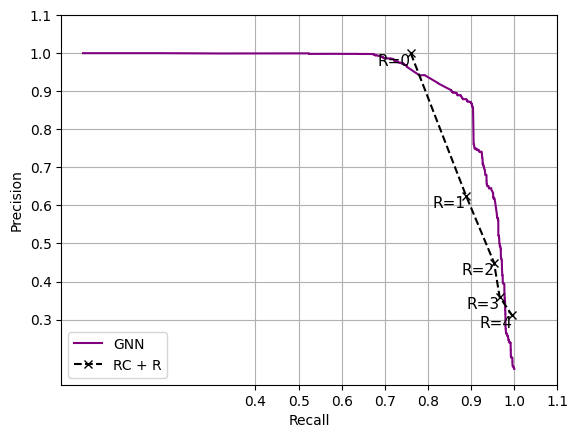

In [27]:
# RC + R stats
recall_from_rcr = [0.76, 0.888, 0.953, 0.966, 0.995]
precision_from_rcr = [1.0, 0.626, 0.450, 0.360, 0.311]
r_labels = [f"R={i}" for i in range(len(recall_from_rcr))]

precision, recall, thresholds = precision_recall_curve(y, ypred)
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple', label="GNN")
ax.plot(recall_from_rcr, precision_from_rcr, ls='--', marker="x", color='black', label="RC + R")
ax.set_xticks(np.arange(0.4, 1.15, 0.1))
ax.set_yticks(np.arange(0.3, 1.15, 0.1))
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
for r, p, label in zip(recall_from_rcr, precision_from_rcr, r_labels):
    ax.text(r, p, label, fontsize=11, ha='right', va='top', color='black')
ax.grid()
ax.legend(loc='lower left')
plt.show()